## Проект спринт 09
**Название проекта**:  
Отток клиентов "Бета-Банка"   
_____
**Описание исследования**:  
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
_____
**Цель исследования**:  
Необходимо построить модель прогноза ухода клиента из банка в ближайшее время.
_____
**План исследования.**  
[Шаг 1. Загрузка и подготовка данных](#step1)  
[Шаг 2. Исследование баланса классов](#step2)  
[Шаг 3. Обучение модели без учёта дисбаланса](#step3)  
[Шаг 4. Улучшение качества модели с учетом дисбаланса классов](#step4)  
[Шаг 5. Финальное тестирование](#step5)  
[Шаг 6. Результаты и выводы](#step6)  
_____
**Исходные данные.**
Исходный файл <a HREF='Churn.csv'>Churn.csv</a>, содержащий исторические данные о поведении клиентов и расторжении договоров с банком.  
поля файла:
Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
Целевой признак
- Exited — факт ухода клиента

<a id='step1'></a>
## Шаг 1. Загрузка и подготовка данных

In [1]:
# загрузка библиотек
import pandas as pd
import seaborn as sns

In [2]:
try:
    df = pd.read_csv('Churn.csv')
    print('Загрузили файл локально')
except:
    print('локально не удалось, загружаем из интернета')
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

Загрузили файл локально


In [3]:
display(df.info())
display(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4763,4764,15696564,Nweke,752,France,Male,38,NaN,145974.79,2,1,1,137694.23,0
3626,3627,15634968,Hsueh,789,Germany,Female,37,6.0,110689.07,1,1,1,71121.04,1
1019,1020,15600583,Garner,633,France,Male,31,1.0,0.00,1,1,0,48606.71,0
4975,4976,15573278,Kennedy,743,France,Male,39,6.0,0.00,2,1,0,44265.28,0
3236,3237,15810800,Ositadimma,673,Spain,Female,32,0.0,0.00,1,1,1,72873.33,0
3823,3824,15585823,Wilson,627,France,Male,31,8.0,128131.73,1,1,0,96131.47,0
2822,2823,15603582,Robertson,569,Spain,Female,34,NaN,0.00,1,1,0,133997.53,0
5177,5178,15588449,Chuang,591,Spain,Female,27,5.0,107812.67,1,0,1,162501.83,1
1996,1997,15755678,Kovalyov,534,France,Male,62,2.0,0.00,2,0,0,42763.12,1
6499,6500,15702561,Dale,782,France,Male,32,9.0,0.00,1,1,1,87566.97,0


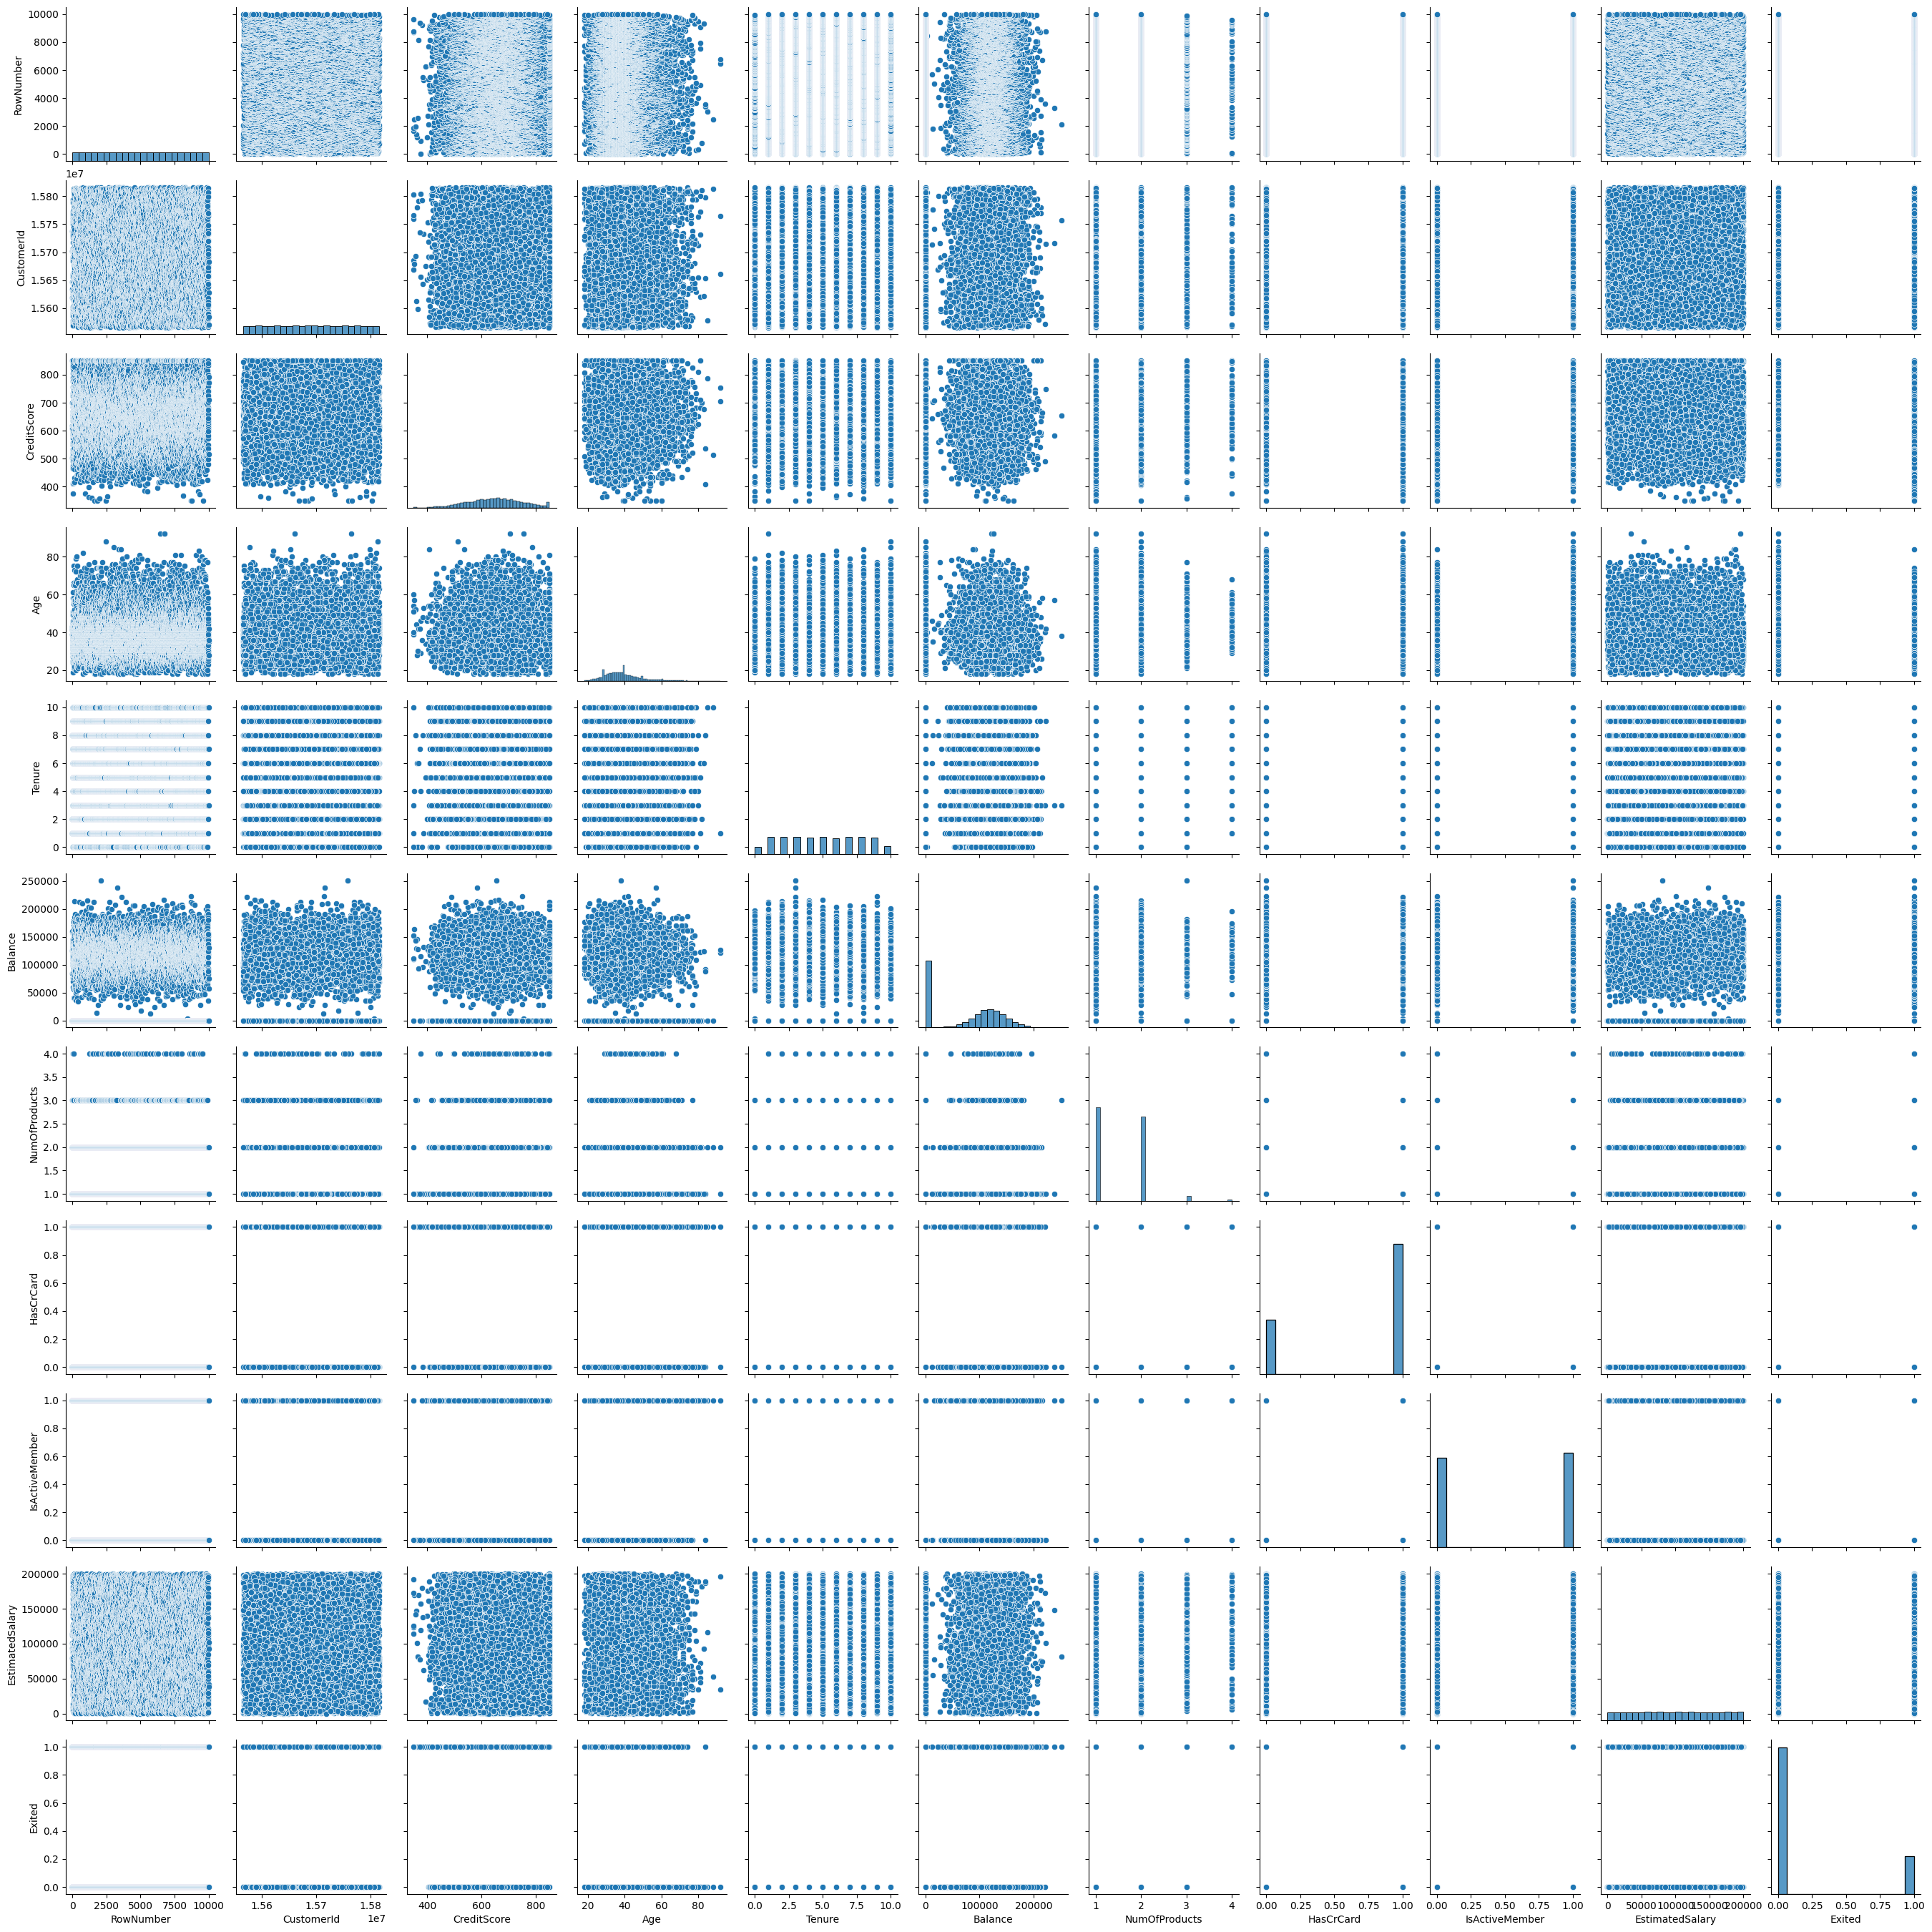

In [4]:
sns.pairplot(df)

<AxesSubplot:>

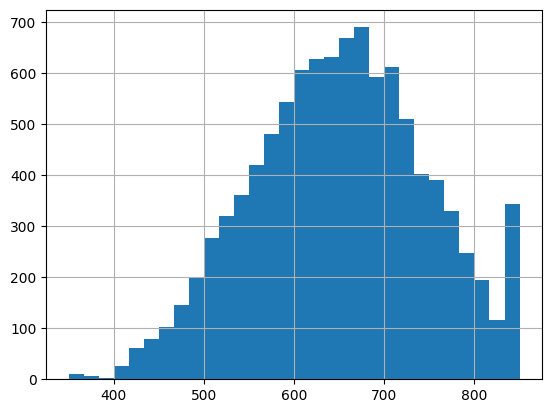

In [5]:
df.CreditScore.hist(bins=30)

<AxesSubplot:>

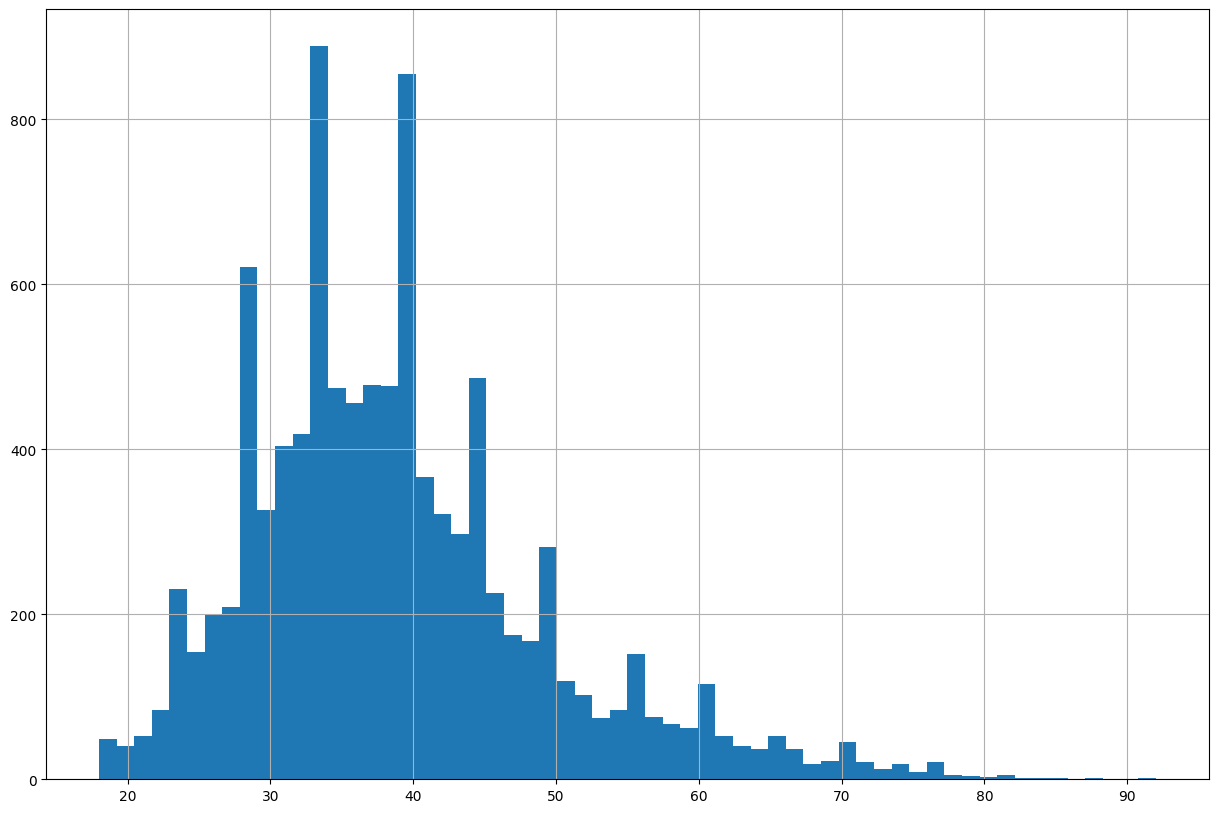

In [6]:
df.Age.hist(bins=60, figsize=(15, 10))

<AxesSubplot:>

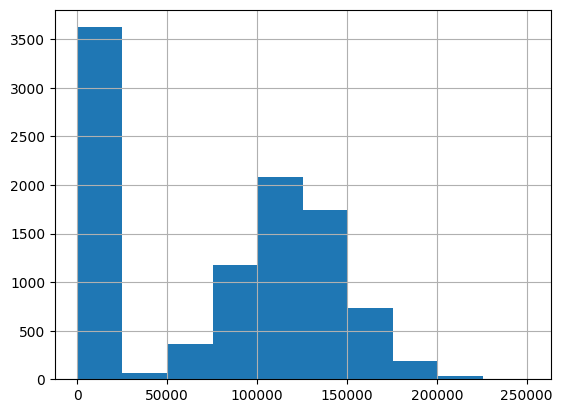

In [7]:
df.Balance.hist()

<AxesSubplot:>

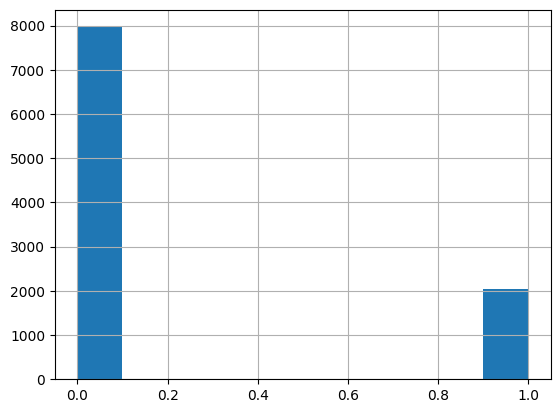

In [8]:
df.Exited.hist()

### первые наблюдения касательно качества данных  
1. Имеется 909 пропусков в поле `Tenure`
2. поля `RowNumber` и `CustomerId` не должны влиять на уход клиента из банка
3. поле `Surname` может являться важной информацией: возможна связь между членами семьи. Однако поскольку внедрение модели предполагает оценку одного конкретного клиента, поле `Surname` также будем считать неважным для модели прогноза
4. Заметны несколько аномалий
   1. Большое количество людей с максимальным кредитным рейтингом - это вполне объяснимо
   2. Отклонения от нормальной кривой распределения возраста - видны максимумы в возрастах 23, 29, 33, 40, 44, 50,55, 60, 70 лет
   3. Большое количество клиентов с нулевым остатком на счете
   4. Целевые классы несбалансированны: из выборки в 10 тысяч клиентов 8 тысяч остаются, 2000 уходят, соотношение примерно 4:1
### план подготовки данных
1. исследовать `Tenure` и заполнить пропуски
2. удалить колонки `RowNumber`, `CustomerId` и `Surname`
3. сконвертировать поля `Geography` и `Gender` в категориальные переменные методом OHE

In [9]:
df[df.Tenure.isna()].sample(20)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
597,598,15567446,Coffman,646,Germany,Male,39,NaN,111574.41,1,1,1,30838.51,0
6213,6214,15697678,Maxwell,590,Germany,Male,36,NaN,92340.69,2,1,1,174667.58,0
2968,2969,15756932,Caldwell,696,Spain,Female,36,NaN,0.00,2,1,1,82298.59,0
2630,2631,15600879,Parsons,554,Germany,Female,36,NaN,157780.93,2,1,0,6089.13,0
3712,3713,15613216,Cameron,639,Spain,Female,39,NaN,141789.15,1,1,0,92455.96,0
7378,7379,15641715,Ts'ui,599,France,Male,34,NaN,0.00,2,1,1,174196.68,0
2619,2620,15800062,Lanford,850,Spain,Male,49,NaN,0.00,1,0,0,25867.67,1
2927,2928,15669656,Macdonald,632,France,Male,32,NaN,111589.33,1,1,1,170382.99,0
8288,8289,15790744,Nash,850,France,Female,34,NaN,92899.27,2,1,0,97465.89,0
5487,5488,15799790,Carter,763,France,Male,35,NaN,0.00,1,1,1,31372.91,0


Особенностей незаметно, заполним пропущенные значения медианой

In [10]:
m = df.Tenure.median()
df.loc[df.Tenure.isna(),'Tenure'] = m

In [11]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [18]:
display(df.Geography.unique())
display(df.Gender.unique())

array(['France', 'Spain', 'Germany'], dtype=object)

array(['Female', 'Male'], dtype=object)

In [20]:
categorial=['Geography', 'Gender']
numeric = ['CreditScore', ]

In [21]:
df = pd.get_dummies(data=df, columns=categorial, drop_first=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


<a id='step2'></a>
## Шаг 2. Исследование баланса классов

<a id='step3'></a>
## Шаг 3. Обучение модели без учёта дисбаланса

<a id='step4'></a>
## Шаг 4. Улучшение качества модели с учетом дисбаланса классов

<a id='step5'></a>
## Шаг 5. Финальное тестирование

<a id='step6'></a>
## Шаг 6. Результаты и выводы